In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from mapping_methods import lca_mapping
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

False


In [102]:
PATH = "Thesis/Embeddings"

sl = "en"
tl = "fr"
model_name = "bert-base-multilingual-uncased"

sl_vec = np.load(PATH + "/" + f"{sl}/" + f"emb_{model_name}_{sl}.npy",mmap_mode="r")
tl_vec = np.load(PATH + "/" + f"{tl}/" + f"emb_{model_name}_{tl}.npy",mmap_mode="r")

size = 5000

sl_vec = torch.as_tensor(sl_vec[:size])
tl_vec = torch.as_tensor(tl_vec[:size])

sl_train, sl_test, tl_train, tl_test = train_test_split(sl_vec, tl_vec, test_size=0.25, random_state=42)

sl_train, sl_test = sl_train.T, sl_test.T
tl_train, tl_test = tl_train.T, tl_test.T

ts = TSNE(n_components=2, perplexity=30, n_iter=5000, learning_rate=0.0001)

sl_tl_map = lca_mapping(sl_train, sl_test, tl_train, tl_test)

print(sl_tl_map.shape)

sl_ts = ts.fit_transform(sl_vec)
tl_ts = ts.fit_transform(tl_vec)

mapped_sl = np.dot(sl_vec, sl_tl_map)
mapped_tl = np.dot(tl_vec, sl_tl_map)

print(mapped_sl.shape)

mapped_sl_ts = ts.fit_transform(mapped_sl)
mapped_tl_ts = ts.fit_transform(mapped_tl)

print(mapped_tl.shape, mapped_tl_ts.shape)

torch.Size([768, 1250])
(5000, 1250)
(5000, 1250) (5000, 2)


In [135]:
def scatter_plot(x_data, y_data, color_choice, title, path):
	plt.figure(figsize=(16,9))
	custom_palette = ["#FF4252", "#638AFF", "#CC5EFF"]
	sns.set_context("talk", rc={"grid.linewidth": 2.5})
	sns.set_style("whitegrid", {"grid.color": "0.6"})
	sns.set_palette(sns.color_palette(custom_palette)[color_choice:])
	plot = sns.scatterplot(x=x_data, y=y_data, edgecolor="#595959", linewidth=0.6) 
	plot.tick_params(axis="x", colors="#595959", width=5, labelsize=25)
	plot.tick_params(axis="y", colors="#595959", width=5, labelsize=25)

	plot.spines["bottom"].set_linewidth(6)
	plot.spines["bottom"].set_color("#595959")

	plot.spines["left"].set_linewidth(6)
	plot.spines["left"].set_color("#595959")

	sns.despine()
	plt.title(title, color="#595959", size=50)

	plt.savefig(path, transparent=True, bbox_inches="tight")
	plt.show()

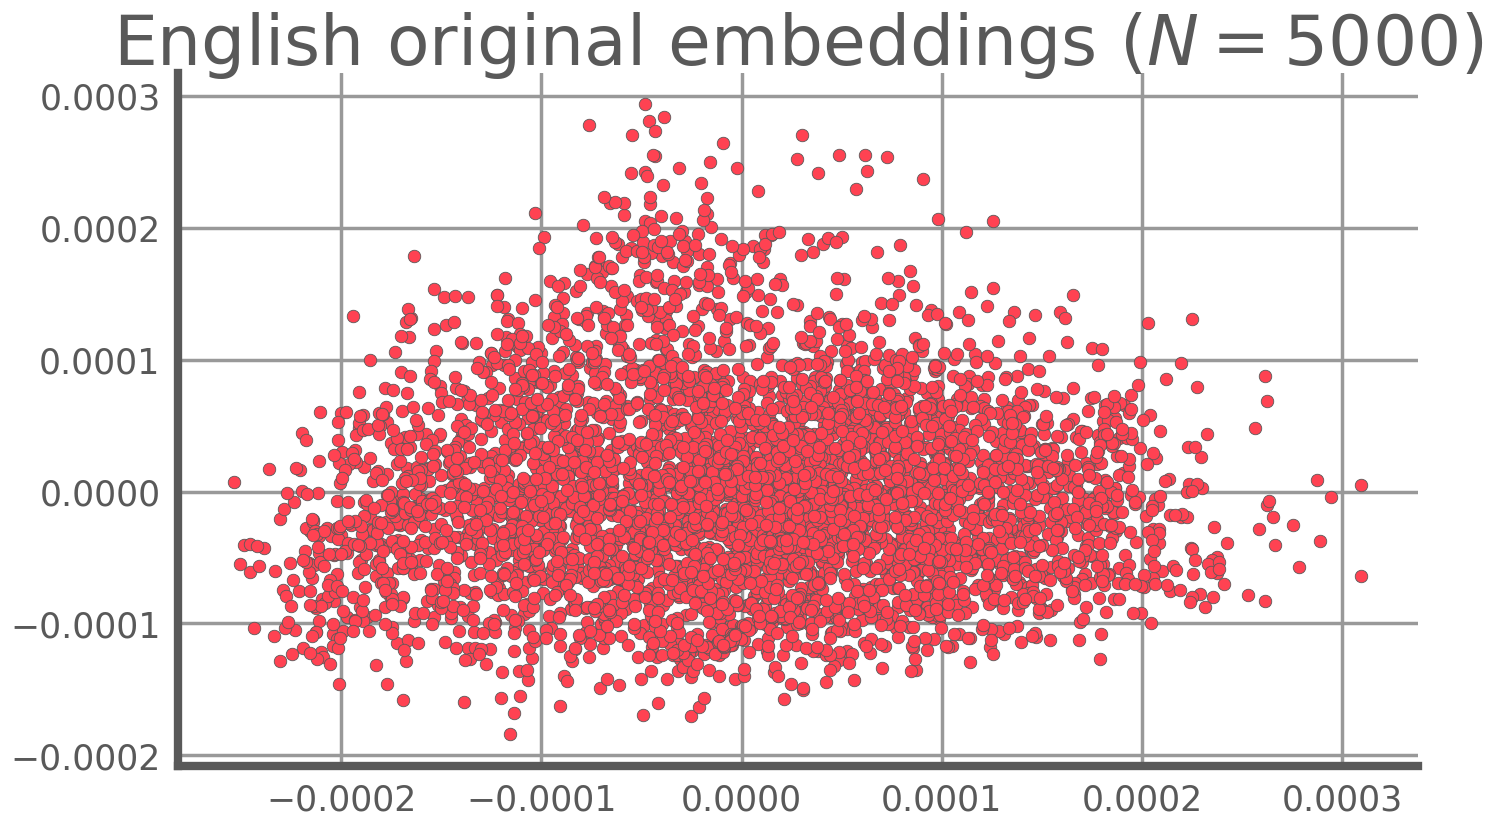

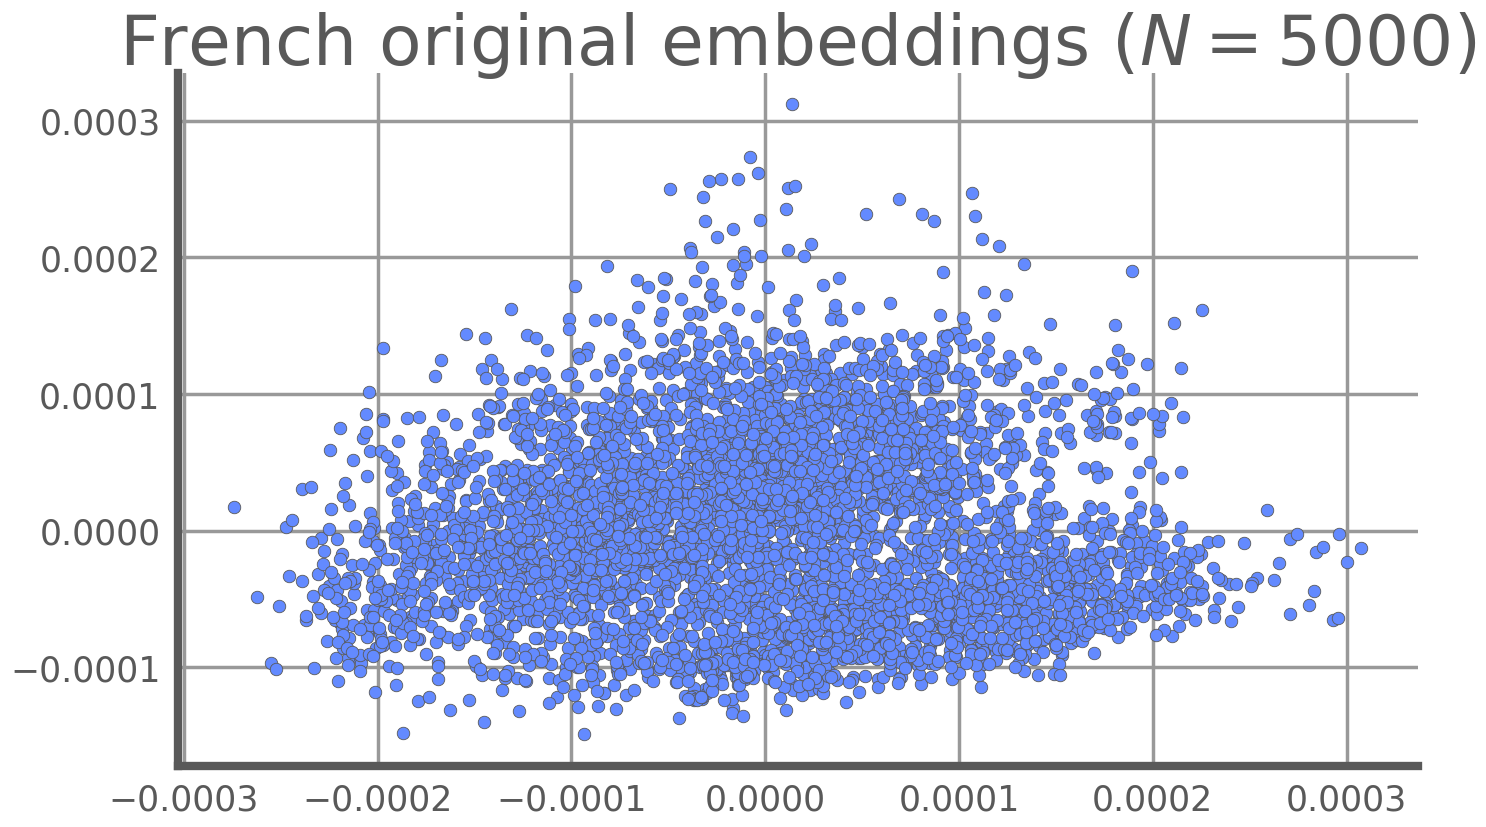

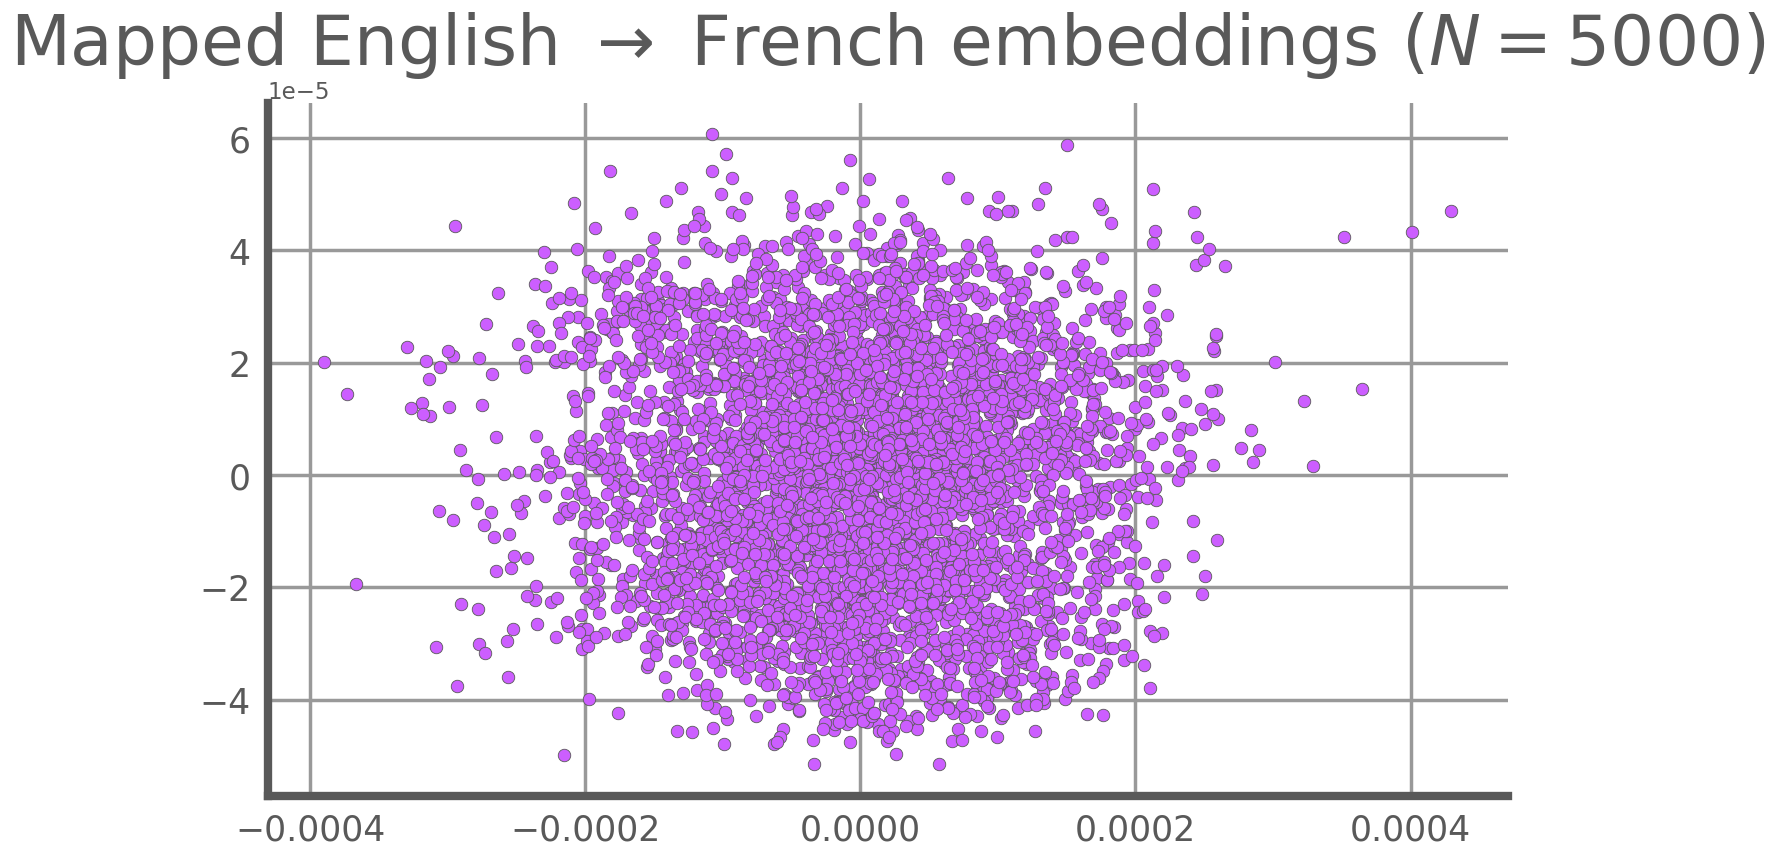

In [136]:
samples = 5000

scatter_plot(sl_ts[:samples,0], sl_ts[:samples,1], 0, f"English original embeddings ($N={samples}$)", "Thesis/visualisations/embedding_en.png")
scatter_plot(tl_ts[:samples,0], tl_ts[:samples,1], 1, f"French original embeddings ($N={samples}$)", "Thesis/visualisations/embedding_fr.png")
scatter_plot(mapped_sl_ts[:samples,0], mapped_sl_ts[:samples,1], 2, f"Mapped English $\\rightarrow$ French embeddings ($N={samples}$)", "Thesis/visualisations/embedding_mapped_en-fr.png")

In [6]:
import json

results_lca = json.load(open("Thesis/Results/reciprocal_rank/en-fr/lca_en-fr.json", "r"))
results_lca = results_lca["en-fr"]
results_lca = np.mean(np.asarray([score for score in results_lca.values()]), axis=0)

results_lcc = json.load(open("Thesis/Results/reciprocal_rank/en-fr/lcc_en-fr.json", "r"))
results_lcc = results_lcc["en-fr"]
results_lcc = np.mean(np.asarray([score for score in results_lcc.values()]), axis=0)

results_nnca = json.load(open("Thesis/Results/reciprocal_rank/en-fr/nnca_en-fr.json", "r"))
results_nnca = results_nnca["en-fr"]
results_nnca = np.mean(np.asarray([score for score in results_nnca.values()]), axis=0)

results = {"LCA": results_lca, "LCC": results_lcc, "NNCA": results_nnca}

In [7]:
model_plot_names = {
    "bert-base-multilingual-uncased": "mBERT uncased",
    "mt5-base": "MT5",
    "xlm-roberta-base": "XLM-Roberta",
    "ernie-m-base_pytorch": "ErnieM"    
}

dims = [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 768]

In [8]:
def plot_mate_scores(sl, tl, mate_scores, dims, path, evaluation_function):
  sns.set_context("talk", rc={"grid.linewidth": 2.5})
  sns.set_style("whitegrid", {"grid.color": "0.6"})
  sns.color_palette("husl")
  plt.figure(figsize=(16,9))

  for method, score in mate_scores.items():
    score = np.array(score)
    
    y_en = score[:,0]
    y_no_mapping = score[:,1]
    y_en_max = np.argmax(y_en)
    y_no_mapping_max = np.argmax(y_no_mapping)
    x_dim = dims

    plot = sns.lineplot(x=x_dim,y=y_en,label=method, linewidth=3)
    sns.scatterplot(y=[y_en[y_en_max]], x=[x_dim[y_en_max]],label=f"{x_dim[y_en_max]} - {y_en[y_en_max]:.4f}", marker="^",s=150)
    
  sns.lineplot(x=x_dim,y=y_no_mapping,label="not mapped", linewidth=3)
  sns.scatterplot(y=[y_no_mapping[y_no_mapping_max]], x=[x_dim[y_no_mapping_max]],label=f"{x_dim[y_no_mapping_max]} - {y_no_mapping[y_no_mapping_max]:.4f}", marker="^",s=150)

  sns.despine()
  plot.tick_params(axis="x", colors="#595959", width=5)
  plot.tick_params(axis="y", colors="#595959", width=5)

  plot.spines["bottom"].set_linewidth(4)
  plot.spines["bottom"].set_color("#595959")

  plot.spines["left"].set_linewidth(4)
  plot.spines["left"].set_color("#595959")
  
  plt.title(f"{evaluation_function} across dimensions for {sl}-{tl}", fontsize=40, color="#595959")
  
  plt.xlabel("Dimension", fontsize=30, color="#595959")
  plt.ylabel(evaluation_function.title(), fontsize=30, color="#595959")
  plt.xticks(fontsize=25)
  plt.yticks(fontsize=25)
  sns.move_legend(plot, "upper left", bbox_to_anchor=(1,1), fontsize=20, fancybox=True, framealpha=0, labelcolor="#595959")

  plt.savefig(path + f"EN_FR_{evaluation_function}.png", transparent=True, bbox_inches="tight")
  plt.show()

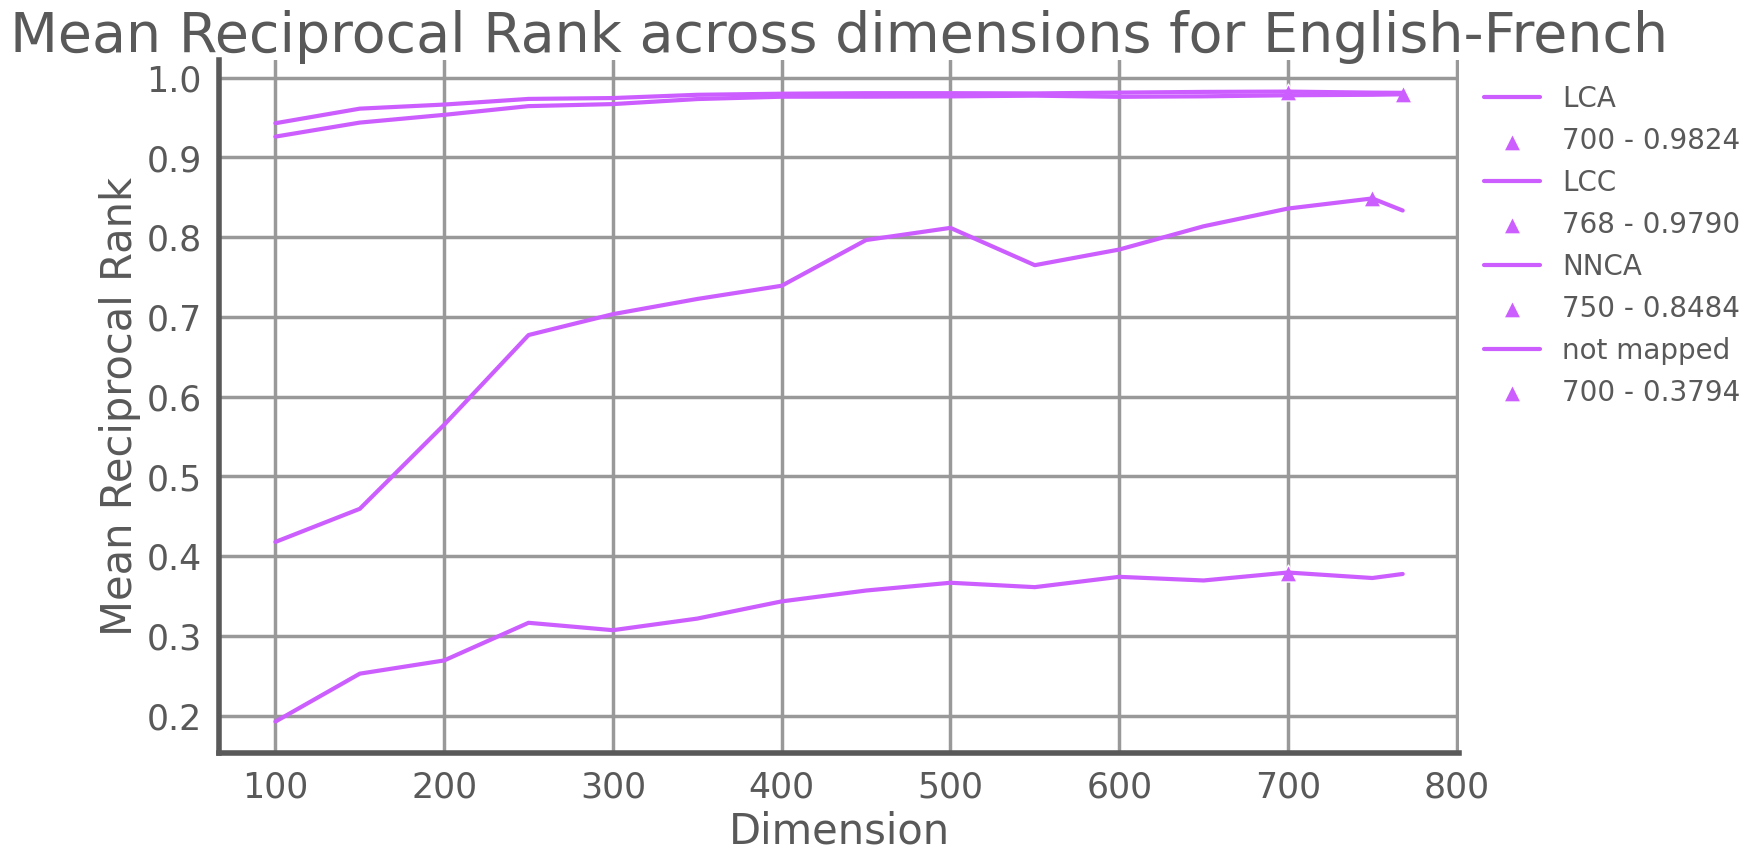

In [9]:
plot_mate_scores("English", "French", results, dims, "Thesis/visualisations/", "Mean Reciprocal Rank")

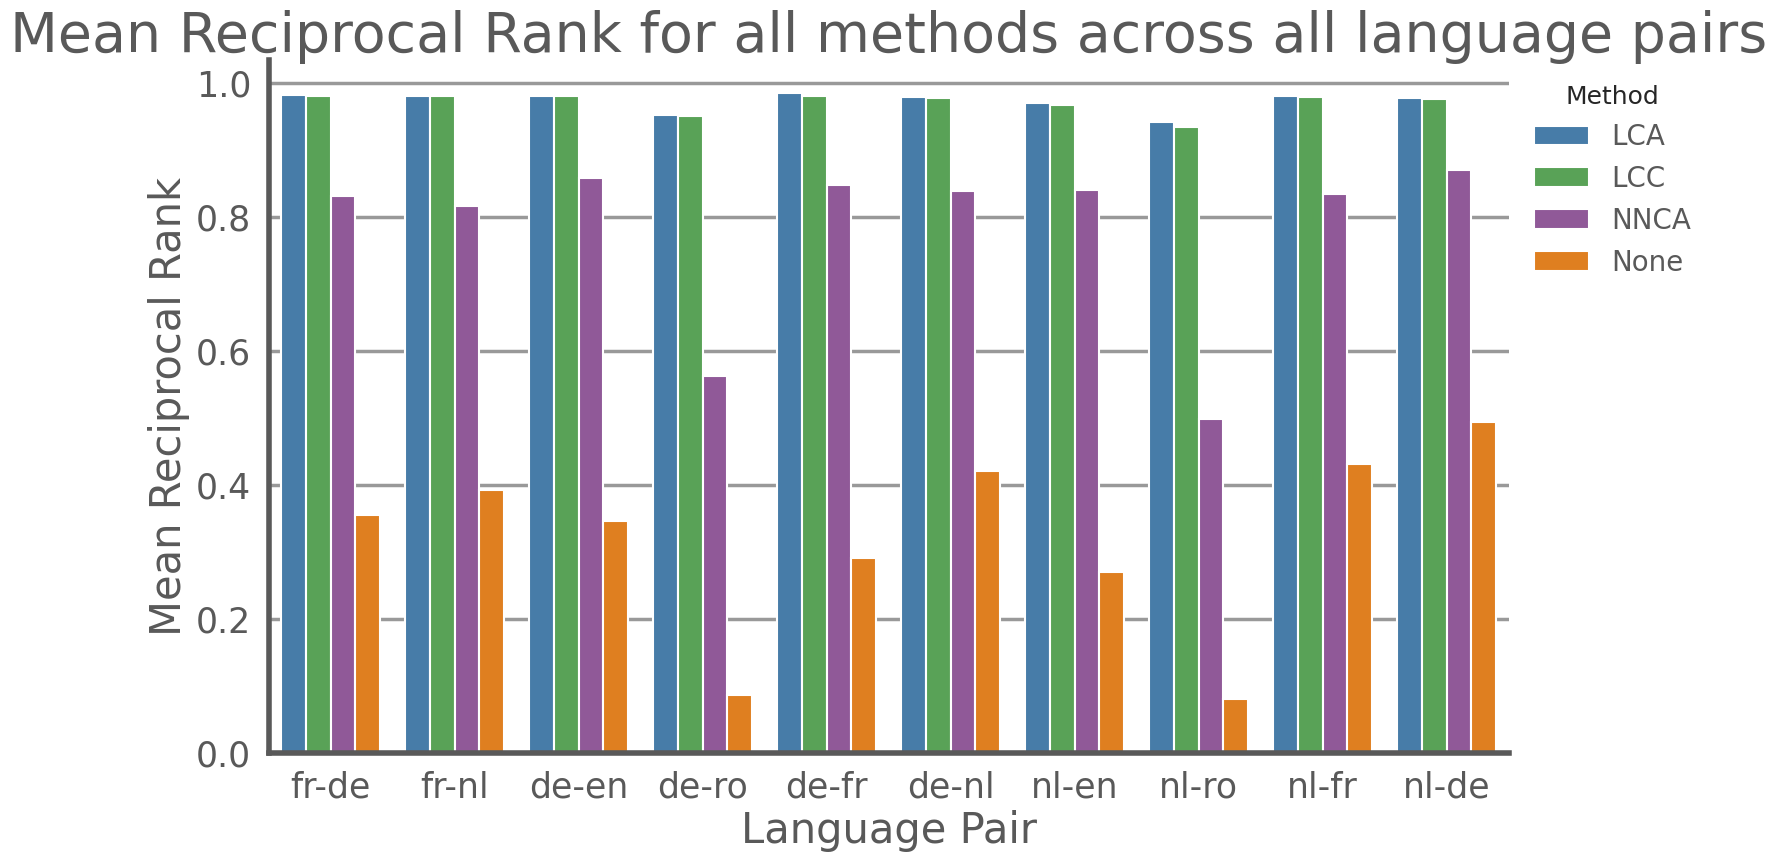

In [10]:
import os
import pandas as pd
from collections import defaultdict

rel_path = "Thesis/Results/reciprocal_rank"

# language, LCA, LCC, NCCA

df = defaultdict(lambda : [])
for folder in os.listdir(rel_path)[10:20]:
	results_lca = json.load(open(f"Thesis/Results/reciprocal_rank/{folder}/lca_{folder}.json", "r"))
	results_lca = results_lca[folder]
	results_lca = np.mean(np.asarray([score for score in results_lca.values()]), axis=0)

	results_lcc = json.load(open(f"Thesis/Results/reciprocal_rank/{folder}/lcc_{folder}.json", "r"))
	results_lcc = results_lcc[folder]
	results_lcc = np.mean(np.asarray([score for score in results_lcc.values()]), axis=0)

	results_nnca = json.load(open(f"Thesis/Results/reciprocal_rank/{folder}/nnca_{folder}.json", "r"))
	results_nnca = results_nnca[folder]
	results_nnca = np.mean(np.asarray([score for score in results_nnca.values()]), axis=0)

	results_lca = np.max(results_lca, axis=0)[:-2].item()
	results_lcc = np.max(results_lcc, axis=0)[:-2].item()
	results_no = np.max(results_nnca, axis=0)[-2].item()
	results_nnca = np.max(results_nnca, axis=0)[:-2].item()

	df["language"].append(folder)
	df["language"].append(folder)
	df["language"].append(folder)
	df["language"].append(folder)
	df["Method"].append("LCA")
	df["score"].append(results_lca)
	df["Method"].append("LCC")
	df["score"].append(results_lcc)
	df["Method"].append("NNCA")
	df["score"].append(results_nnca)
	df["Method"].append("None")
	df["score"].append(results_no)

df = pd.DataFrame(df)

evaluation_function = "Mean Reciprocal Rank"

sns.set_context("talk", rc={"grid.linewidth": 2.5})
sns.set_style("whitegrid", {"grid.color": "0.6"})
sns.set_palette(sns.color_palette("Set1", 16)[10:])
plt.figure(figsize=(16,9))

plot = sns.barplot(data=df, x="language", y="score", hue="Method")

sns.despine()
plot.tick_params(axis="x", colors="#595959", width=5)
plot.tick_params(axis="y", colors="#595959", width=5)

plot.spines["bottom"].set_linewidth(4)
plot.spines["bottom"].set_color("#595959")

plot.spines["left"].set_linewidth(4)
plot.spines["left"].set_color("#595959")

plt.title(f"{evaluation_function} for all methods across all language pairs", fontsize=40, color="#595959")

plt.xlabel("Language Pair", fontsize=30, color="#595959")
plt.ylabel(evaluation_function.title(), fontsize=30, color="#595959")
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
sns.move_legend(plot, "upper left", bbox_to_anchor=(1,1), fontsize=20, fancybox=True, framealpha=0, labelcolor="#595959")
plt.savefig("Thesis/visualisations/" + f"all_{evaluation_function}_20.png", transparent=True, bbox_inches="tight")
plt.show()